In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import talib

from sklearn.metrics import classification_report,confusion_matrix,mean_absolute_error as mae, mean_absolute_percentage_error as mape
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.model_selection import TimeSeriesSplit

from feature_engine.selection import DropFeatures
from feature_engine.datetime import DatetimeFeatures

import warnings
warnings.filterwarnings("ignore")

In [2]:
import lightgbm as lgb
from sklearn.linear_model import Ridge

In [3]:
def getData(stockName,period,interval):
    return yf.download(tickers=stockName, period=period, interval=interval)

In [12]:
df=getData('EURUSD=X','1y','1h')

[*********************100%***********************]  1 of 1 completed


In [16]:
df['atr'] = talib.ATR(df['High'],df['Low'], df['Close'],timeperiod=8)

In [17]:
df.head(20)

,Open,High,Low,Close,Adj Close,Volume,atr
Datetime,,,,,,,
2022-06-27 00:00:00+01:00,1.056859,1.057641,1.056747,1.056859,1.056859,0,NaN
2022-06-27 01:00:00+01:00,1.057418,1.057418,1.055743,1.055855,1.055855,0,NaN
2022-06-27 02:00:00+01:00,1.056078,1.056971,1.056078,1.056747,1.056747,0,NaN
2022-06-27 03:00:00+01:00,1.056636,1.056859,1.055855,1.055855,1.055855,0,NaN
2022-06-27 04:00:00+01:00,1.055855,1.056189,1.055298,1.055855,1.055855,0,NaN
2022-06-27 05:00:00+01:00,1.055855,1.057083,1.055743,1.056747,1.056747,0,NaN
2022-06-27 06:00:00+01:00,1.056747,1.057418,1.056301,1.056301,1.056301,0,NaN
2022-06-27 07:00:00+01:00,1.056412,1.057083,1.055855,1.056971,1.056971,0,NaN
2022-06-27 08:00:00+01:00,1.056971,1.059434,1.056859,1.059098,1.059098,0,0.001368


In [5]:
df['Close-1']=df['Close'].shift(1)
df=df.dropna()

In [6]:
df['diff']=df['Close']-df['Close-1']
df['label']=np.where(df['diff']>0,1,0)

In [7]:
df

,Close,Close-1,diff,label
Datetime,,,,
2022-06-27 01:00:00+01:00,1.055855,1.056859,-0.001004,0
2022-06-27 02:00:00+01:00,1.056747,1.055855,0.000893,1
2022-06-27 03:00:00+01:00,1.055855,1.056747,-0.000893,0
2022-06-27 04:00:00+01:00,1.055855,1.055855,0.000000,0
2022-06-27 05:00:00+01:00,1.056747,1.055855,0.000893,1
...,...,...,...,...
2023-06-26 18:00:00+01:00,1.091346,1.091227,0.000119,1
2023-06-26 19:00:00+01:00,1.091703,1.091346,0.000357,1
2023-06-26 20:00:00+01:00,1.090988,1.091703,-0.000715,0


In [ ]:
atr = talib.ATR(high_prices, low_prices, close_prices)

In [10]:
df['sma'] = talib.SMA(df['Close'], timeperiod=20)
df['rsi'] = talib.RSI(df['Close'], timeperiod=14)
df['kama'] = talib.KAMA(df['Close'], timeperiod=10)

In [11]:
for i in ['Close','sma','rsi','kama']:
    for j in [3,4,5,6,7]:
        df[f'{i}_lag_{j}']=df[i].shift(j)

In [12]:
df=df.dropna().reset_index()

In [13]:
df

,Datetime,Close,Close-1,diff,label,sma,rsi,kama,Close_lag_3,Close_lag_4,...,rsi_lag_3,rsi_lag_4,rsi_lag_5,rsi_lag_6,rsi_lag_7,kama_lag_3,kama_lag_4,kama_lag_5,kama_lag_6,kama_lag_7
0,2022-06-20 00:00:00+01:00,1.049208,1.049759,-0.000551,0,1.050093,40.179729,1.050011,1.049759,1.049538,...,41.911875,41.002737,39.687959,30.618706,31.784897,1.050038,1.050045,1.050062,1.050093,1.050246
1,2022-06-20 01:00:00+01:00,1.049648,1.049208,0.000441,1,1.049955,42.420224,1.050004,1.049648,1.049759,...,41.566969,41.911875,41.002737,39.687959,30.618706,1.050024,1.050038,1.050045,1.050062,1.050093
2,2022-06-20 02:00:00+01:00,1.049648,1.049648,0.000000,0,1.049783,42.420224,1.049938,1.049759,1.049648,...,42.080273,41.566969,41.911875,41.002737,39.687959,1.050020,1.050024,1.050038,1.050045,1.050062
3,2022-06-20 03:00:00+01:00,1.052189,1.049648,0.002540,1,1.049783,53.951797,1.050408,1.049208,1.049759,...,40.179729,42.080273,41.566969,41.911875,41.002737,1.050011,1.050020,1.050024,1.050038,1.050045
4,2022-06-20 04:00:00+01:00,1.053075,1.052189,0.000886,1,1.049911,57.175066,1.051236,1.049648,1.049208,...,42.420224,40.179729,42.080273,41.566969,41.911875,1.050004,1.050011,1.050020,1.050024,1.050038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6178,2023-06-16 16:00:00+01:00,1.092657,1.092777,-0.000119,0,1.094655,48.558907,1.094390,1.095410,1.096371,...,64.035409,70.797797,65.265862,68.997156,68.997156,1.094457,1.094404,1.094255,1.094247,1.094225
6179,2023-06-16 17:00:00+01:00,1.093733,1.092657,0.001076,1,1.094602,53.527720,1.094373,1.095530,1.095410,...,64.491805,64.035409,70.797797,65.265862,68.997156,1.094508,1.094457,1.094404,1.094255,1.094247
6180,2023-06-16 18:00:00+01:00,1.094212,1.093733,0.000479,1,1.094578,55.584340,1.094372,1.092777,1.095530,...,49.100313,64.491805,64.035409,70.797797,65.265862,1.094456,1.094508,1.094457,1.094404,1.094255
6181,2023-06-16 19:00:00+01:00,1.094811,1.094212,0.000599,1,1.094560,58.083924,1.094376,1.092657,1.092777,...,48.558907,49.100313,64.491805,64.035409,70.797797,1.094390,1.094456,1.094508,1.094457,1.094404


In [14]:
X_df = df.drop(columns=['Close','Close-1','diff','label','Datetime','sma','rsi','kama'])
y_df = df['Close']

In [18]:
X = np.array(X_df)
y = np.array(y_df)

tscv = TimeSeriesSplit(n_splits=10)  # Specify the number of splits (number of folds)

# Perform time series cross-validation
scr = []
df_s = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model = lgb.LGBMRegressor()
    model.fit(X_train,y_train)
    preds = model.predict(X_test)
    scr.append(mape(y_test,preds))
    
    df_s.append(pd.DataFrame(y_test,preds).reset_index().rename(columns={'index':'Real',0:'Pred'}))
    
    

In [19]:
np.mean(scr)

0.004048315921059271

In [20]:
[i*100 for i in scr]

[0.2594954163465093,
 0.5006454935057736,
 0.48479783337026344,
 0.25304894641021397,
 0.4493017465785728,
 1.275151508818822,
 0.14920085297896504,
 0.18043785792378325,
 0.3768715237555364,
 0.11936474137083129]

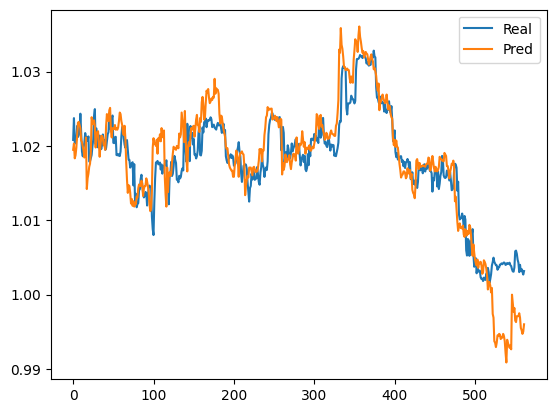

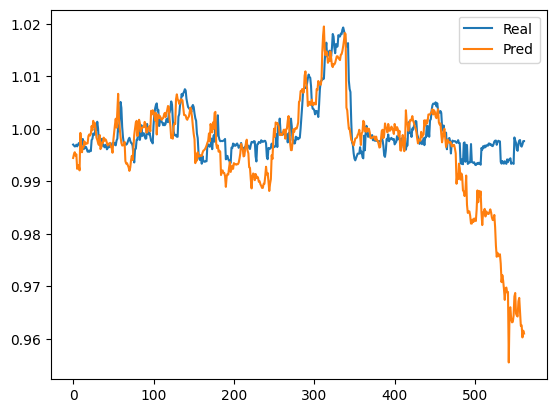

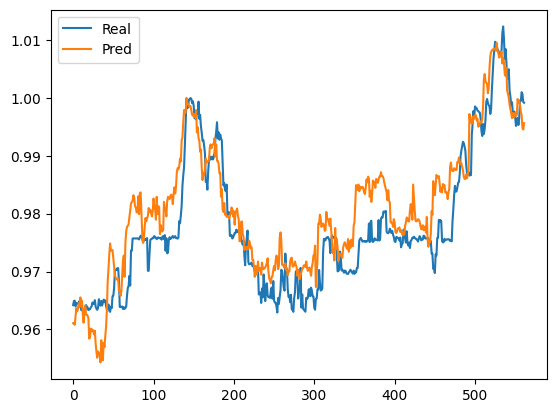

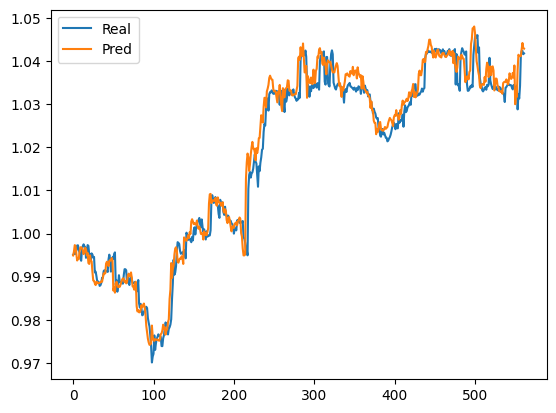

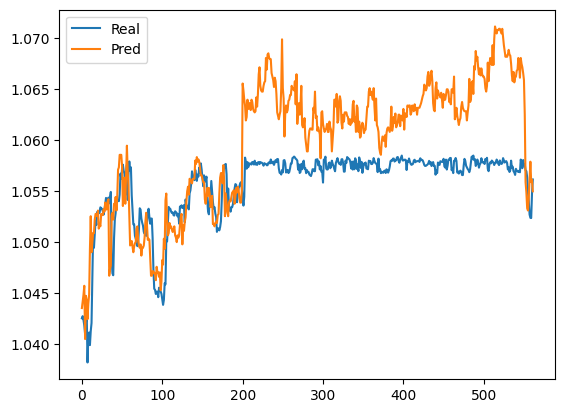

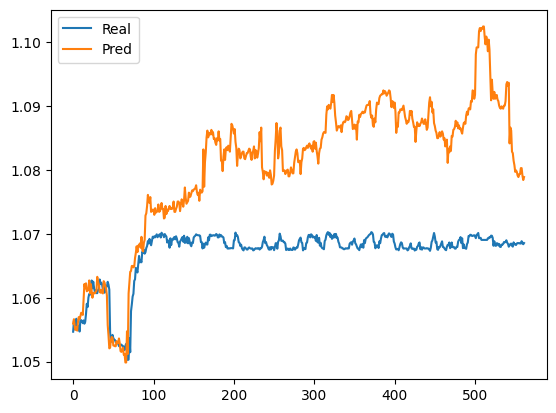

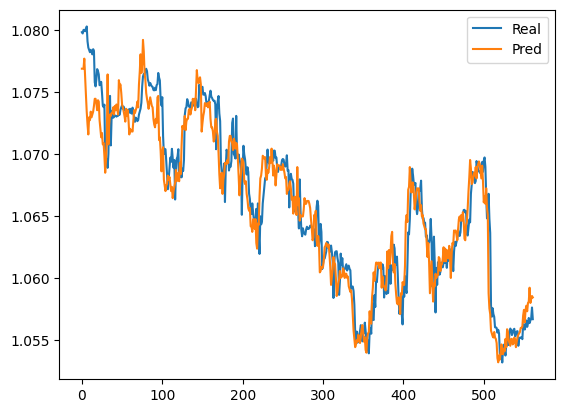

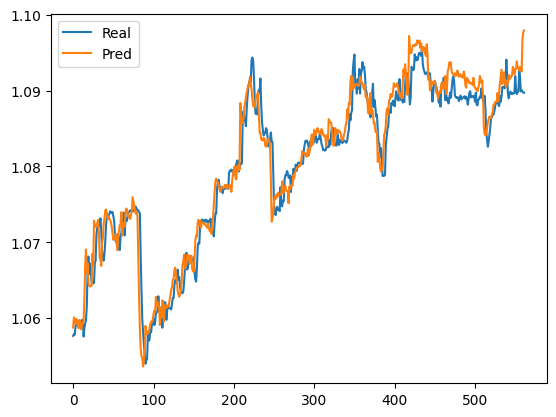

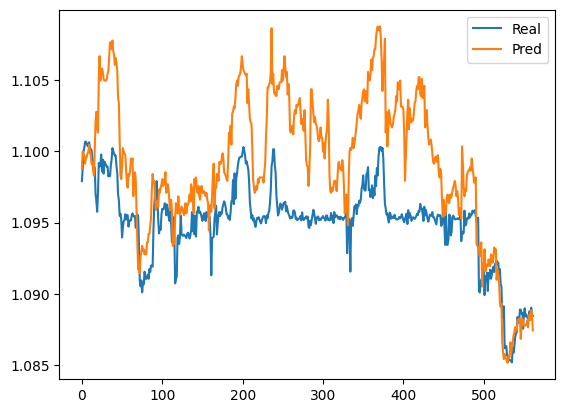

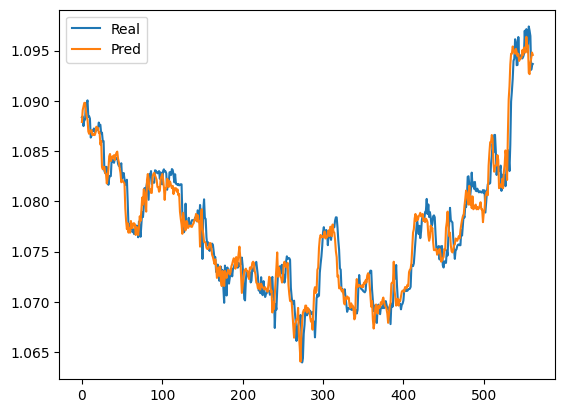

In [21]:
for i in df_s:
    i.plot()

In [22]:
rt=round(len(X_df)*0.6)
rv=rt+round(len(X_df)*0.2)

In [23]:
X_tr = X_df[:rt]
X_val = X_df[rt:rv]
X_ts = X_df[rv:]

y_tr = y_df[:rt]
y_val = y_df[rt:rv]
y_ts = y_df[rv:]

In [25]:
model = lgb.LGBMRegressor()
model.fit(X_tr,y_tr)

LGBMRegressor()

In [26]:
val_pred = model.predict(X_val)
test_pred = model.predict(X_ts)

In [27]:
mape(y_val,val_pred)

0.002121488759532675

In [28]:
mape(y_ts,test_pred)

0.0064905587516542965

<Axes: >

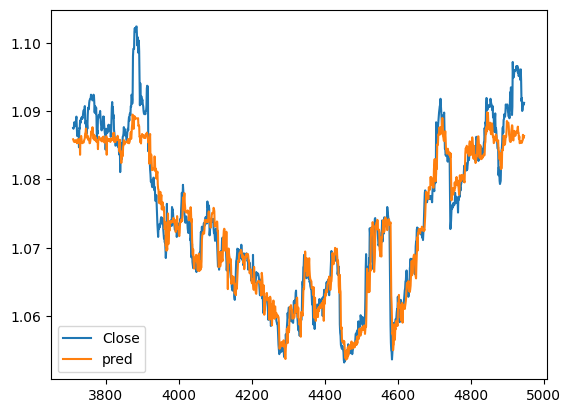

In [29]:
y_df=y_val.to_frame()
y_df['pred']=val_pred
y_df.plot()

<Axes: >

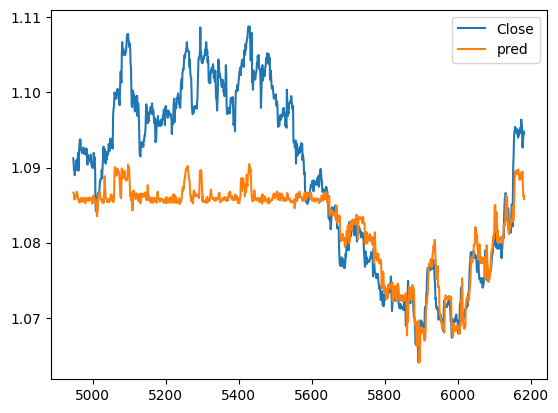

In [30]:
y_df=y_ts.to_frame()
y_df['pred']=test_pred
y_df.plot()